# Load libraries and set parameters

In [1]:
import torch
from torch import nn
import torch.nn.functional as F

import torch
import pandas as pd
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
from tqdm import tqdm

import torchvision.transforms as transforms
from torchvision.datasets import EMNIST
from torch.utils.data import DataLoader, random_split, Subset

import torchvision
from torchinfo import summary

import torchvision
from torch import optim, nn
import timeit



RANDOM_SEED = 42
BATCH_SIZE = 512
EPOCHS = 40
LEARNING_RATE = 1e-4
NUM_CLASSES = 10
PATCH_SIZE = 4
IMG_SIZE = 28
IN_CHANNELS = 1
NUM_HEADS = 8
DROPOUT = 0.001
ADAM_WEIGHT_DECAY = 0
ADAM_BETAS = (0.9, 0.999)
NUM_ENCODERS = 4
EMBED_DIM = (PATCH_SIZE ** 2) * IN_CHANNELS # 16
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2 # 49

# Expansion of the MLP 
EXPANSION = 128



random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


device = "cuda" if torch.cuda.is_available() else "cpu"



# Patch Embedding class

In [2]:
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        self.patcher = nn.Sequential(
            # We use conv instead of linear for efficiency
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                # if kernel_size = stride -> no overlap
                kernel_size=patch_size,
                stride=patch_size
            ),
            # Linear projection of Flattened Patches. We keep the batch and we channels (b,c,h,w)
            nn.Flatten(2))
        self.cls_token = nn.Parameter(torch.randn(size=(1, 1, embed_dim)), requires_grad=True)
        self.position_embeddings = nn.Parameter(torch.randn(size=(1, num_patches+1, embed_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        # Create a copy of the cls token for each of the elements of the BATCH
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        # Create the patches
        x = self.patcher(x).permute(0, 2, 1)
        # Unify the position with the patches
        x = torch.cat([cls_token, x], dim=1)
        # Patch + Position Embedding
        x = self.position_embeddings + x
        x = self.dropout(x)
        return x
    
patchemb = PatchEmbedding(EMBED_DIM, PATCH_SIZE, NUM_PATCHES, DROPOUT, IN_CHANNELS).to(device)
x = torch.randn(512, 1, 28, 28).to(device)


In [3]:
a=patchemb(x)
a.shape

torch.Size([512, 50, 16])

# ViT using a TransformerEncoderLayer from scratch

In [4]:
class MLP(nn.Module):
    def __init__(self, embed_dim, expansion, dropout):
        super().__init__()
        self.fc1 = nn.Linear(embed_dim, embed_dim*expansion)
        self.gelu = nn.GELU()
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(embed_dim*expansion, embed_dim)
        self.dropout2 = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.gelu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)

        return x
        
        # Compacted one:
        # x = self.fc2(self.dropout1(self.gelu(self.fc1(x))))
        # return self.dropout2(x)

In [36]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"

        self.W_q = nn.Linear(embed_dim, embed_dim)
        self.W_k = nn.Linear(embed_dim, embed_dim)
        self.W_v = nn.Linear(embed_dim, embed_dim)
        
        self.W_o = nn.Linear(embed_dim, embed_dim)
        self.attention_dropout = nn.Dropout(dropout)
        
    def split_heads(self, x, batch_size):
        x = x.view(batch_size, -1, self.num_heads, self.head_dim)
        return x.permute(0, 2, 1, 3)  # (batch_size, num_heads, seq_length, head_dim)
        
    def forward(self, x, mask=None):
        batch_size = x.size(0)
        
        # Linear projections
        queries = self.W_q(x)
        keys = self.W_k(x)
        values = self.W_v(x)
        
        # Split heads
        queries = self.split_heads(queries, batch_size)
        keys = self.split_heads(keys, batch_size)
        values = self.split_heads(values, batch_size)
        
        # Scaled dot-product attention
        scaling = self.head_dim ** 0.5
        attention = torch.matmul(queries, keys.permute(0,1,3,2)) / scaling
        
        # Apply mask (optional)
        if mask is not None:
            attention = attention.masked_fill(mask == 0, float('-inf'))
        
        attention = F.softmax(attention, dim=-1)
        
        # Apply dropout to attention weights
        attention = self.attention_dropout(attention)
        
        # Attention output
        attention = torch.matmul(attention, values)

        # Concatenate heads
        attention = attention.view(batch_size, -1, self.embed_dim)
        
        # Final linear projection
        attention = self.W_o(attention)
        
        return attention


In [38]:
a.shape

torch.Size([512, 50, 16])

In [39]:
nn.Linear(16, 16).to(device)(a).shape

torch.Size([512, 50, 16])

In [40]:
a.shape

torch.Size([512, 50, 16])

In [41]:
nn.Linear(16, 16).to(device)(a).shape

torch.Size([512, 50, 16])

In [44]:
MultiHeadAttention(16, 4, 0.001).to(device)(a).shape

torch.Size([512, 50, 16])

In [45]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, expansion, dropout):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.MHA = MultiHeadAttention(embed_dim, num_heads, dropout)
        self.dropout = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, expansion, dropout)
    
        
    def forward(self, x):
        norm1 = self.norm1(x)
        # Skip connection 1
        x = x + self.MHA(norm1)
        x = self.dropout(x)
        
        norm2 = self.norm2(x)
        # Skip connection 2
        x = x + self.mlp(norm2)
        x = self.dropout(x)
        
        return x


In [46]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, expansion, dropout, num_encoders):
        super().__init__()
        self.layers = nn.ModuleList([TransformerEncoderLayer(embed_dim, num_heads, expansion, dropout) for _ in range(num_encoders)])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [47]:
class ViT_scratch(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels, num_heads, num_encoders, expansion, num_classes):
        super().__init__()
        self.embedded_patches = PatchEmbedding(embed_dim, patch_size, num_patches, dropout, in_channels)
        
        self.transformer_encoder =  TransformerEncoder(embed_dim, num_heads, expansion, dropout, num_encoders)
        
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes)
        )
        
    def forward(self, x):
        x = self.embedded_patches(x)
        x = self.transformer_encoder(x)
        x = self.mlp_head(x[:,0,:])
        return x

In [48]:
model3 = ViT_scratch(EMBED_DIM, PATCH_SIZE, NUM_PATCHES, DROPOUT, IN_CHANNELS, NUM_HEADS, NUM_ENCODERS, EXPANSION, NUM_CLASSES).to(device)
x = torch.randn(512, 1, 28, 28).to(device)
print(model3(x).shape) # BATCH_SIZE X NUM_CLASSES

torch.Size([512, 10])


In [49]:
model3

ViT_scratch(
  (embedded_patches): PatchEmbedding(
    (patcher): Sequential(
      (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(4, 4))
      (1): Flatten(start_dim=2, end_dim=-1)
    )
    (dropout): Dropout(p=0.001, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (MHA): MultiHeadAttention(
          (W_q): Linear(in_features=16, out_features=16, bias=True)
          (W_k): Linear(in_features=16, out_features=16, bias=True)
          (W_v): Linear(in_features=16, out_features=16, bias=True)
          (W_o): Linear(in_features=16, out_features=16, bias=True)
          (attention_dropout): Dropout(p=0.001, inplace=False)
        )
        (dropout): Dropout(p=0.001, inplace=False)
        (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (fc1): Linear(in_features=16, out_features=2048

In [50]:

print("\nSummary of the model3 (using scratch functions):")
summary(model3, input_size=(1, 1, 28, 28))


Summary of the model3 (using scratch functions):


Layer (type:depth-idx)                        Output Shape              Param #
ViT_scratch                                   [1, 10]                   --
├─PatchEmbedding: 1-1                         [1, 50, 16]               816
│    └─Sequential: 2-1                        [1, 16, 49]               --
│    │    └─Conv2d: 3-1                       [1, 16, 7, 7]             272
│    │    └─Flatten: 3-2                      [1, 16, 49]               --
│    └─Dropout: 2-2                           [1, 50, 16]               --
├─TransformerEncoder: 1-2                     [1, 50, 16]               --
│    └─ModuleList: 2-3                        --                        --
│    │    └─TransformerEncoderLayer: 3-3      [1, 50, 16]               68,752
│    │    └─TransformerEncoderLayer: 3-4      [1, 50, 16]               68,752
│    │    └─TransformerEncoderLayer: 3-5      [1, 50, 16]               68,752
│    │    └─TransformerEncoderLayer: 3-6      [1, 50, 16]               68,752
├─

### 

# Load EMNIST dataset

In [51]:
# Define transformations
train_transform = transforms.Compose([
    transforms.RandomRotation(15),  # Random rotation for training data
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets

train_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=train_transform)
val_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=val_test_transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=val_test_transform)





Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:03<00:00, 2582923.23it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 473554.42it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4377999.89it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2559179.04it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [52]:
train_dataset = Subset(train_data, range(48000))
val_dataset = Subset(val_data, range(48000, len(val_data)))

In [53]:
num_workers = torch.cuda.device_count() * 4
num_workers

4

In [54]:
train_dataloader = DataLoader(dataset=train_dataset,
                              num_workers=num_workers, pin_memory=False,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset,
                            num_workers=num_workers, pin_memory=False,
                            batch_size=BATCH_SIZE,
                            shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset,
                        num_workers=num_workers, pin_memory=False,
                        batch_size=BATCH_SIZE,
                        shuffle=False)

___

# Training

In [55]:
model3 = ViT_scratch(EMBED_DIM, PATCH_SIZE, NUM_PATCHES, DROPOUT, IN_CHANNELS, NUM_HEADS, NUM_ENCODERS, EXPANSION, NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model3.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)


In [56]:
EPOCHS = 50
print("Showing the first 30 elements of each epoch!")
# Save losses and accuracies for plot
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training
start = timeit.default_timer()
for epoch in tqdm(range(EPOCHS), position=0, leave=True):
    model3.train()
    train_labels = []
    train_preds = []
    train_running_loss = 0
    for idx, (data, target) in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = data.float().to(device)
        label = target.type(torch.uint8).to(device)
        optimizer.zero_grad()
        y_pred = model3(img)
        y_pred_label = torch.argmax(y_pred, dim=1)
        train_labels.extend(label.cpu().detach())
        train_preds.extend(y_pred_label.cpu().detach())
        loss = criterion(y_pred, label)
        train_running_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss / (idx + 1)
    
    # Saving metrics of training
    train_accuracy = sum(1 for x,y in zip(train_preds, train_labels) if x==y) / len(train_labels)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    
    

    model3.eval()
    
    # Validation
    
    val_labels = []
    val_preds = []
    val_running_loss = 0
    with torch.no_grad():
        for idx, (data, target) in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = data.float().to(device)
            label = target.type(torch.uint8).to(device)
            y_pred = model3(img)
            y_pred_label = torch.argmax(y_pred, dim=1)
            val_labels.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())
            loss = criterion(y_pred, label)
            val_running_loss += loss.item()

    val_loss = val_running_loss / (idx + 1)
    
    # Saving metrics of validation
    val_accuracy = sum(1 for x,y in zip(val_preds, val_labels) if x==y) / len(val_labels)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    # Showing labels while training
    train_labels_array =  np.array([y.detach().numpy() for y in train_labels])
    train_preds_array = np.array([y.detach().numpy() for y in train_preds])
    val_labels_array =  np.array([y.detach().numpy() for y in val_labels])
    val_preds_array = np.array([y.detach().numpy() for y in val_preds])
    print("*" * 30)
    print(f"EPOCH {epoch+1}")
    print("Training predictions:   ", train_preds_array[:30])
    print("Training labels:        ", train_labels_array[:30])
    print("Validation predictions: ", val_preds_array[:30])
    print("Validation labels:      ", val_labels_array[:30])
    print("-" * 30)
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Valid Loss: {val_loss:.4f}")
    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Valid Accuracy: {val_accuracy:.4f}")
    print("*" * 30)

     
stop= timeit.default_timer()
print(f"Training Time: {stop-start:.2f} s")

Showing the first 30 elements of each epoch!


  2%|▏         | 1/50 [00:09<08:01,  9.82s/it]

******************************
EPOCH 1
Training predictions:    [2 0 2 2 2 9 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Training labels:         [8 2 0 6 2 9 1 1 9 8 2 9 9 6 1 4 5 7 4 0 2 5 5 2 6 0 2 8 9 4]
Validation predictions:  [1 7 7 7 7 1 1 1 7 1 7 1 7 7 7 1 7 1 7 7 1 7 7 1 1 1 7 7 7 1]
Validation labels:       [4 8 6 2 2 5 7 1 4 2 9 1 1 0 4 6 5 4 6 0 1 5 2 7 4 9 8 0 2 1]
------------------------------
Train Loss: 2.3054
Valid Loss: 2.2916
Train Accuracy: 0.1156
Valid Accuracy: 0.1248
******************************


  4%|▍         | 2/50 [00:19<07:47,  9.74s/it]

******************************
EPOCH 2
Training predictions:    [1 7 7 1 1 1 7 1 7 1 1 1 1 7 1 7 7 1 7 1 7 7 1 7 7 1 1 7 1 1]
Training labels:         [9 3 0 3 1 8 0 1 2 9 1 1 4 7 3 3 8 2 2 7 4 8 8 3 3 1 8 2 3 9]
Validation predictions:  [0 0 0 8 4 4 8 3 1 2 7 8 1 1 2 3 0 4 1 0 1 2 4 2 2 4 4 0 4 8]
Validation labels:       [0 2 2 8 4 9 2 5 1 3 3 6 9 5 0 3 0 9 1 0 1 5 7 2 3 3 4 0 9 5]
------------------------------
Train Loss: 2.0823
Valid Loss: 1.7366
Train Accuracy: 0.2343
Valid Accuracy: 0.3973
******************************


  6%|▌         | 3/50 [00:29<07:48,  9.97s/it]

******************************
EPOCH 3
Training predictions:    [8 7 3 3 4 7 8 4 3 1 1 4 4 4 9 0 2 4 4 0 8 0 4 0 0 5 4 4 4 2]
Training labels:         [1 9 5 3 5 7 6 8 0 7 1 9 4 4 7 8 2 4 9 2 2 0 9 0 8 4 4 9 4 6]
Validation predictions:  [3 2 7 2 6 1 1 4 7 7 5 8 6 7 6 4 7 0 2 0 4 4 6 1 7 2 7 7 0 4]
Validation labels:       [3 8 8 3 6 1 9 9 7 7 7 8 4 7 6 7 7 0 2 0 5 4 6 1 7 3 3 7 0 5]
------------------------------
Train Loss: 1.6483
Valid Loss: 1.4246
Train Accuracy: 0.4525
Valid Accuracy: 0.5748
******************************


  8%|▊         | 4/50 [00:39<07:36,  9.93s/it]

******************************
EPOCH 4
Training predictions:    [8 2 2 3 4 4 0 3 3 4 7 4 0 3 8 0 3 2 3 6 5 9 0 1 0 0 8 3 3 0]
Training labels:         [3 1 3 5 4 7 0 2 3 4 8 9 0 3 9 0 7 0 2 6 7 3 0 1 0 9 8 8 5 0]
Validation predictions:  [2 1 4 4 5 1 5 4 6 6 0 5 5 2 1 2 0 0 0 3 6 5 8 8 2 1 9 1 4 4]
Validation labels:       [2 1 4 9 5 1 7 4 6 6 0 7 5 2 1 3 3 0 0 3 6 7 8 8 2 1 9 1 4 4]
------------------------------
Train Loss: 1.4267
Valid Loss: 1.2421
Train Accuracy: 0.5683
Valid Accuracy: 0.6575
******************************


 10%|█         | 5/50 [00:49<07:21,  9.81s/it]

******************************
EPOCH 5
Training predictions:    [6 3 1 1 5 3 1 9 4 1 0 4 4 1 4 1 9 0 6 1 2 3 2 6 0 3 7 2 6 4]
Training labels:         [1 3 5 1 8 9 1 9 9 1 0 4 5 1 4 1 9 8 6 3 2 3 2 9 6 3 7 8 6 9]
Validation predictions:  [3 3 1 1 5 6 5 6 9 1 8 0 9 0 0 7 3 7 0 3 0 7 7 1 9 6 6 9 9 0]
Validation labels:       [3 3 1 1 5 6 5 6 9 7 8 0 4 0 0 5 3 7 0 5 0 7 3 1 8 6 6 7 3 0]
------------------------------
Train Loss: 1.2746
Valid Loss: 1.1031
Train Accuracy: 0.6362
Valid Accuracy: 0.7096
******************************


 12%|█▏        | 6/50 [00:59<07:14,  9.87s/it]

******************************
EPOCH 6
Training predictions:    [1 5 4 2 7 5 3 7 2 3 3 9 2 1 6 7 6 3 2 8 7 4 4 4 3 1 6 4 7 6]
Training labels:         [5 5 9 1 5 5 5 7 2 3 3 9 2 1 6 5 6 3 8 8 3 4 9 4 3 8 6 4 7 8]
Validation predictions:  [3 1 9 4 6 8 8 1 8 3 6 4 7 3 4 2 4 6 8 3 0 7 6 2 2 3 7 8 6 9]
Validation labels:       [2 1 8 4 6 8 3 1 1 3 0 4 7 3 4 2 9 6 8 3 0 7 6 2 7 3 5 8 6 4]
------------------------------
Train Loss: 1.1470
Valid Loss: 0.9725
Train Accuracy: 0.6853
Valid Accuracy: 0.7597
******************************


 14%|█▍        | 7/50 [01:08<06:58,  9.74s/it]

******************************
EPOCH 7
Training predictions:    [3 7 0 4 1 9 4 4 6 7 1 8 3 5 1 2 8 9 6 3 7 6 1 6 3 9 5 6 7 1]
Training labels:         [3 7 0 4 1 9 4 9 4 7 1 8 3 5 1 2 8 9 5 3 7 6 1 6 3 9 5 4 7 1]
Validation predictions:  [1 3 0 9 9 1 7 3 1 4 0 8 3 2 8 9 0 1 6 1 2 0 3 0 3 9 9 6 0 2]
Validation labels:       [1 3 0 4 9 1 3 3 1 4 0 8 3 3 6 4 0 5 6 1 2 0 5 0 3 9 9 6 0 2]
------------------------------
Train Loss: 1.0423
Valid Loss: 0.8764
Train Accuracy: 0.7226
Valid Accuracy: 0.7907
******************************


 16%|█▌        | 8/50 [01:18<06:52,  9.82s/it]

******************************
EPOCH 8
Training predictions:    [1 7 1 6 9 3 3 5 3 6 0 8 1 0 9 4 0 1 5 9 4 4 2 6 0 3 0 9 8 1]
Training labels:         [1 7 1 6 9 3 7 5 3 6 0 8 1 0 4 4 0 1 5 9 4 6 7 6 0 5 3 9 4 2]
Validation predictions:  [8 0 2 7 0 0 7 1 0 1 4 3 2 2 5 2 3 1 9 1 4 5 0 4 0 4 6 9 3 7]
Validation labels:       [8 0 2 2 0 0 7 1 0 1 9 3 2 2 5 3 5 1 8 1 4 5 0 4 0 4 6 9 5 7]
------------------------------
Train Loss: 0.9494
Valid Loss: 0.8013
Train Accuracy: 0.7494
Valid Accuracy: 0.8123
******************************


 18%|█▊        | 9/50 [01:28<06:44,  9.87s/it]

******************************
EPOCH 9
Training predictions:    [0 7 1 5 2 7 0 0 9 7 5 5 5 1 7 1 3 2 8 4 2 2 7 4 1 6 0 2 4 4]
Training labels:         [0 7 1 5 2 7 5 8 9 7 5 3 3 1 7 1 3 1 8 4 8 2 7 4 1 6 0 3 4 4]
Validation predictions:  [0 0 7 6 2 5 6 8 4 1 2 7 7 9 4 3 9 6 3 0 5 3 8 0 2 0 3 4 2 6]
Validation labels:       [0 0 7 6 2 5 0 8 4 1 2 7 7 9 4 3 9 6 5 8 4 3 8 0 2 0 3 9 2 6]
------------------------------
Train Loss: 0.8662
Valid Loss: 0.7124
Train Accuracy: 0.7743
Valid Accuracy: 0.8382
******************************


 20%|██        | 10/50 [01:38<06:32,  9.82s/it]

******************************
EPOCH 10
Training predictions:    [0 6 2 0 1 6 5 4 1 6 2 5 8 1 6 1 9 1 3 7 4 1 1 5 5 2 4 8 7 5]
Training labels:         [0 6 2 0 1 6 6 9 1 6 2 5 8 1 2 1 9 1 3 7 4 1 1 5 5 2 4 1 7 5]
Validation predictions:  [5 0 5 4 2 4 1 7 0 9 9 5 8 5 0 4 1 0 2 6 5 0 7 9 4 8 1 0 8 5]
Validation labels:       [5 6 5 4 2 9 1 7 0 9 9 5 8 5 0 9 1 0 2 6 5 0 7 9 4 8 1 0 2 3]
------------------------------
Train Loss: 0.7990
Valid Loss: 0.6464
Train Accuracy: 0.7951
Valid Accuracy: 0.8546
******************************


 22%|██▏       | 11/50 [01:48<06:25,  9.87s/it]

******************************
EPOCH 11
Training predictions:    [4 7 0 1 0 6 6 5 2 8 7 2 7 0 2 9 3 4 9 7 0 9 2 0 0 6 2 5 7 3]
Training labels:         [4 7 0 1 0 6 6 3 2 8 7 9 7 0 2 4 3 4 9 2 0 9 2 0 2 2 2 5 7 2]
Validation predictions:  [8 4 7 1 8 2 1 3 5 7 4 9 1 3 4 9 6 5 2 1 7 1 0 6 8 1 0 8 1 5]
Validation labels:       [8 7 7 1 8 2 1 3 5 7 4 9 1 3 4 9 6 8 8 1 7 1 0 6 8 8 0 8 1 5]
------------------------------
Train Loss: 0.7384
Valid Loss: 0.5875
Train Accuracy: 0.8112
Valid Accuracy: 0.8692
******************************


 24%|██▍       | 12/50 [01:58<06:17,  9.93s/it]

******************************
EPOCH 12
Training predictions:    [4 2 8 3 7 0 4 9 1 8 1 8 9 9 1 1 6 4 0 6 5 4 7 0 7 0 8 7 9 0]
Training labels:         [4 2 5 3 7 0 4 9 8 8 1 8 9 9 1 8 6 4 2 6 5 4 9 0 7 0 2 7 8 0]
Validation predictions:  [7 6 7 2 3 6 9 0 4 7 1 7 7 0 7 0 2 4 3 2 6 5 4 2 2 7 7 9 1 3]
Validation labels:       [7 2 7 8 5 6 4 0 4 7 1 7 7 0 7 0 2 4 3 2 0 5 4 1 6 7 7 9 1 3]
------------------------------
Train Loss: 0.6728
Valid Loss: 0.5462
Train Accuracy: 0.8320
Valid Accuracy: 0.8766
******************************


 26%|██▌       | 13/50 [02:08<06:07,  9.94s/it]

******************************
EPOCH 13
Training predictions:    [4 0 3 4 4 6 1 5 9 3 2 0 9 1 8 6 2 5 5 4 9 5 7 9 4 0 6 8 6 7]
Training labels:         [4 0 3 4 4 6 1 5 4 3 2 0 9 1 8 6 2 5 5 4 8 5 7 9 4 2 6 8 6 7]
Validation predictions:  [3 8 0 7 3 8 5 8 9 5 0 0 0 8 8 2 7 5 8 8 9 4 5 2 6 8 1 4 6 2]
Validation labels:       [3 8 0 7 3 8 5 8 9 9 0 0 0 8 8 2 7 5 8 8 9 4 5 2 6 8 1 4 6 2]
------------------------------
Train Loss: 0.6319
Valid Loss: 0.4998
Train Accuracy: 0.8406
Valid Accuracy: 0.8870
******************************


 28%|██▊       | 14/50 [02:18<05:58,  9.96s/it]

******************************
EPOCH 14
Training predictions:    [8 8 7 2 9 6 1 6 5 6 2 9 1 3 6 2 8 6 2 1 0 7 4 6 2 2 6 0 8 9]
Training labels:         [8 8 7 2 9 6 1 6 5 6 2 9 1 5 4 9 8 6 1 1 4 7 4 6 2 2 6 5 8 9]
Validation predictions:  [6 6 9 1 1 3 0 1 1 1 5 0 7 4 6 0 3 8 9 0 1 2 0 6 4 1 8 5 0 2]
Validation labels:       [6 6 7 1 1 3 0 1 1 1 3 0 7 4 6 0 3 8 9 0 1 2 0 6 4 1 8 5 0 2]
------------------------------
Train Loss: 0.5867
Valid Loss: 0.4508
Train Accuracy: 0.8520
Valid Accuracy: 0.9011
******************************


 30%|███       | 15/50 [02:28<05:48,  9.96s/it]

******************************
EPOCH 15
Training predictions:    [3 6 8 3 0 3 8 6 5 3 8 7 4 1 9 2 9 5 5 1 7 3 5 1 5 9 3 6 1 1]
Training labels:         [3 6 8 3 0 3 8 6 5 3 8 2 4 1 8 2 9 5 5 1 7 3 5 1 8 9 5 6 1 1]
Validation predictions:  [8 7 7 6 9 1 1 1 6 4 7 0 7 5 7 1 3 2 7 6 9 4 7 5 9 2 8 2 4 6]
Validation labels:       [8 7 7 6 4 1 1 1 6 4 7 0 7 5 7 1 3 2 7 6 9 4 7 5 9 2 8 2 4 6]
------------------------------
Train Loss: 0.5541
Valid Loss: 0.4289
Train Accuracy: 0.8589
Valid Accuracy: 0.8992
******************************


 32%|███▏      | 16/50 [02:38<05:41, 10.05s/it]

******************************
EPOCH 16
Training predictions:    [5 7 2 8 8 1 0 0 5 2 0 1 5 7 1 9 1 9 7 9 5 2 9 3 9 6 3 5 3 9]
Training labels:         [5 7 2 8 8 1 0 0 5 2 0 1 5 7 1 5 1 9 7 4 5 2 9 3 9 6 3 5 3 9]
Validation predictions:  [3 1 7 6 7 7 0 4 5 8 7 7 7 1 3 0 9 0 6 8 4 9 4 8 9 2 9 9 6 7]
Validation labels:       [3 3 7 6 7 7 0 4 5 8 7 1 7 1 3 0 9 0 6 8 4 9 4 8 9 2 4 9 6 7]
------------------------------
Train Loss: 0.5128
Valid Loss: 0.3931
Train Accuracy: 0.8694
Valid Accuracy: 0.9117
******************************


 34%|███▍      | 17/50 [02:48<05:28,  9.95s/it]

******************************
EPOCH 17
Training predictions:    [8 5 9 4 7 2 8 7 9 2 7 1 3 8 9 9 6 1 3 2 5 9 4 9 1 2 9 8 1 9]
Training labels:         [4 5 9 4 7 2 3 7 9 2 3 1 3 8 9 9 6 1 3 2 5 9 4 9 1 2 9 8 1 9]
Validation predictions:  [7 0 6 6 7 8 6 6 9 3 5 1 1 6 4 9 4 1 2 4 0 7 9 6 8 9 9 9 7 4]
Validation labels:       [7 0 6 6 2 8 6 6 9 3 5 1 1 6 4 9 9 1 2 9 0 7 9 6 8 9 9 9 7 4]
------------------------------
Train Loss: 0.4887
Valid Loss: 0.3791
Train Accuracy: 0.8732
Valid Accuracy: 0.9101
******************************


 36%|███▌      | 18/50 [02:58<05:17,  9.93s/it]

******************************
EPOCH 18
Training predictions:    [8 1 0 3 0 1 8 9 1 1 6 4 6 2 2 0 9 8 3 1 8 7 3 4 4 3 6 3 5 4]
Training labels:         [8 1 0 8 0 1 8 9 1 1 6 4 6 2 2 0 9 8 3 1 8 7 3 4 4 3 6 3 5 4]
Validation predictions:  [0 0 5 5 3 9 8 1 3 7 1 6 3 0 3 9 3 6 7 6 2 3 8 6 7 2 9 7 2 8]
Validation labels:       [0 0 5 5 3 4 8 1 3 7 1 6 3 0 3 9 3 6 7 6 2 3 8 6 7 2 9 7 2 8]
------------------------------
Train Loss: 0.4721
Valid Loss: 0.3655
Train Accuracy: 0.8757
Valid Accuracy: 0.9152
******************************


 38%|███▊      | 19/50 [03:08<05:12, 10.07s/it]

******************************
EPOCH 19
Training predictions:    [9 1 8 7 0 3 1 3 9 7 8 9 7 8 4 7 6 4 4 8 9 6 6 0 5 6 0 5 0 4]
Training labels:         [9 1 8 7 0 3 1 3 7 5 8 9 7 8 4 2 6 4 4 8 4 6 6 6 5 6 0 5 0 4]
Validation predictions:  [8 2 2 7 3 0 1 9 2 4 5 1 7 0 3 1 5 1 8 8 1 1 4 8 0 4 9 0 9 2]
Validation labels:       [8 2 2 7 3 0 1 9 2 4 5 1 7 0 3 7 5 1 8 8 1 1 4 9 0 4 9 0 9 2]
------------------------------
Train Loss: 0.4530
Valid Loss: 0.3281
Train Accuracy: 0.8790
Valid Accuracy: 0.9227
******************************


 40%|████      | 20/50 [03:18<05:01, 10.04s/it]

******************************
EPOCH 20
Training predictions:    [7 9 5 3 6 5 2 7 7 1 5 0 0 6 4 2 0 1 3 8 3 4 3 1 9 8 8 8 2 9]
Training labels:         [0 9 5 3 6 5 2 7 3 1 8 0 0 6 4 2 0 1 3 8 3 4 3 1 9 8 8 8 0 9]
Validation predictions:  [6 9 7 3 7 7 1 4 7 6 9 6 0 1 8 8 4 4 2 0 9 0 7 8 3 3 1 3 9 7]
Validation labels:       [6 8 7 3 7 7 1 4 7 6 9 6 0 1 8 8 4 4 2 0 9 0 7 8 3 3 1 3 4 7]
------------------------------
Train Loss: 0.4328
Valid Loss: 0.3237
Train Accuracy: 0.8836
Valid Accuracy: 0.9228
******************************


 42%|████▏     | 21/50 [03:28<04:50, 10.02s/it]

******************************
EPOCH 21
Training predictions:    [2 8 4 8 5 6 0 2 8 0 1 6 8 5 0 7 9 0 1 8 3 6 1 8 8 6 2 2 8 6]
Training labels:         [8 8 4 8 5 6 0 2 8 1 1 6 6 5 0 7 9 0 1 8 3 6 1 8 5 6 2 8 8 6]
Validation predictions:  [8 8 8 3 9 3 2 6 8 6 5 7 1 1 2 9 4 0 0 8 7 2 2 0 0 1 5 1 2 1]
Validation labels:       [8 8 8 3 9 3 2 6 8 6 5 7 1 6 2 5 4 0 0 8 7 2 2 0 0 1 5 1 2 1]
------------------------------
Train Loss: 0.4074
Valid Loss: 0.3065
Train Accuracy: 0.8911
Valid Accuracy: 0.9253
******************************


 44%|████▍     | 22/50 [03:38<04:41, 10.07s/it]

******************************
EPOCH 22
Training predictions:    [3 1 7 8 3 9 6 8 1 4 9 2 7 7 4 2 6 1 9 7 7 9 1 1 9 3 9 8 5 5]
Training labels:         [3 1 7 6 3 9 6 9 1 4 9 2 7 7 4 2 6 1 9 7 2 9 1 1 9 3 9 8 5 5]
Validation predictions:  [0 6 5 6 1 9 4 9 3 8 8 2 1 1 3 8 8 0 5 5 5 4 6 6 7 5 2 6 5 0]
Validation labels:       [0 6 5 6 1 9 4 9 3 5 8 2 1 1 3 8 8 0 5 5 5 9 6 6 7 5 2 0 5 0]
------------------------------
Train Loss: 0.3910
Valid Loss: 0.3013
Train Accuracy: 0.8953
Valid Accuracy: 0.9244
******************************


 46%|████▌     | 23/50 [03:48<04:32, 10.08s/it]

******************************
EPOCH 23
Training predictions:    [4 6 0 2 9 4 2 9 2 3 6 6 1 0 7 9 6 3 1 0 1 8 2 6 2 7 3 4 6 7]
Training labels:         [4 6 0 7 9 4 2 9 2 3 6 6 1 0 7 9 6 3 8 0 1 2 2 6 2 7 3 4 6 7]
Validation predictions:  [1 7 3 8 7 2 0 5 1 1 7 2 8 0 6 8 3 7 6 1 6 2 2 4 1 8 2 3 5 3]
Validation labels:       [1 7 3 8 7 2 0 5 1 1 7 2 8 0 6 8 3 7 6 1 6 2 2 4 1 8 2 3 5 3]
------------------------------
Train Loss: 0.3863
Valid Loss: 0.2758
Train Accuracy: 0.8952
Valid Accuracy: 0.9307
******************************


 48%|████▊     | 24/50 [03:58<04:19,  9.97s/it]

******************************
EPOCH 24
Training predictions:    [7 9 8 3 1 7 2 0 3 1 2 9 5 3 7 4 9 8 4 3 4 9 7 1 7 9 0 2 5 1]
Training labels:         [3 4 8 3 1 7 2 8 3 1 2 9 5 3 2 4 7 8 4 3 4 9 7 1 7 9 0 2 5 1]
Validation predictions:  [1 1 8 5 5 6 6 5 7 4 1 6 5 0 4 6 8 7 8 1 7 8 9 6 2 4 9 8 8 3]
Validation labels:       [1 1 8 5 5 6 6 5 7 4 1 6 5 0 4 6 8 7 8 1 7 8 9 6 2 4 9 8 8 3]
------------------------------
Train Loss: 0.3701
Valid Loss: 0.2851
Train Accuracy: 0.8980
Valid Accuracy: 0.9270
******************************


 50%|█████     | 25/50 [04:08<04:11, 10.06s/it]

******************************
EPOCH 25
Training predictions:    [9 6 4 9 4 6 6 2 6 4 8 7 2 4 7 0 5 0 9 5 9 0 5 0 6 4 5 7 7 7]
Training labels:         [9 6 4 9 9 6 6 2 6 4 3 7 2 4 7 0 5 0 9 5 9 0 5 0 6 4 5 2 7 7]
Validation predictions:  [3 8 3 6 2 3 1 3 6 8 6 4 8 1 4 7 3 1 3 6 7 7 8 6 6 2 7 0 9 6]
Validation labels:       [3 8 9 6 2 3 1 3 6 8 6 4 8 1 4 7 3 1 3 6 7 7 8 6 5 2 7 0 9 6]
------------------------------
Train Loss: 0.3602
Valid Loss: 0.2593
Train Accuracy: 0.8996
Valid Accuracy: 0.9347
******************************


 52%|█████▏    | 26/50 [04:18<04:00, 10.00s/it]

******************************
EPOCH 26
Training predictions:    [9 5 3 2 7 2 5 9 3 4 0 5 7 6 0 2 2 9 7 0 4 4 4 6 0 7 7 7 6 3]
Training labels:         [9 5 3 2 7 9 5 9 3 4 0 5 7 6 5 2 2 9 7 0 4 4 4 6 0 7 7 7 6 3]
Validation predictions:  [9 3 2 0 5 4 8 7 1 5 8 4 7 2 6 4 4 6 7 7 7 8 4 8 0 2 7 3 4 3]
Validation labels:       [9 3 2 0 5 4 8 7 1 5 8 4 7 2 6 4 4 6 7 7 7 8 4 8 0 2 9 3 4 3]
------------------------------
Train Loss: 0.3536
Valid Loss: 0.2511
Train Accuracy: 0.9008
Valid Accuracy: 0.9366
******************************


 54%|█████▍    | 27/50 [04:28<03:49, 10.00s/it]

******************************
EPOCH 27
Training predictions:    [0 9 5 6 7 5 2 9 5 0 0 6 2 4 6 4 4 3 2 8 5 8 1 4 1 4 1 9 6 6]
Training labels:         [0 9 5 6 7 5 2 9 5 0 0 6 2 4 6 4 4 1 2 8 5 9 1 4 8 4 1 4 6 6]
Validation predictions:  [1 8 8 1 2 9 6 5 0 1 4 6 1 5 7 4 4 1 4 0 6 3 3 8 2 0 2 8 0 5]
Validation labels:       [1 8 8 1 2 9 6 5 0 1 4 6 1 5 7 9 4 1 9 0 6 3 3 8 2 0 2 8 0 5]
------------------------------
Train Loss: 0.3363
Valid Loss: 0.2727
Train Accuracy: 0.9049
Valid Accuracy: 0.9276
******************************


 56%|█████▌    | 28/50 [04:38<03:38,  9.93s/it]

******************************
EPOCH 28
Training predictions:    [2 5 4 5 9 1 7 7 2 0 2 5 4 3 7 1 0 6 7 7 7 0 1 9 7 1 9 8 4 2]
Training labels:         [2 5 4 5 9 1 7 7 2 0 2 5 4 3 7 1 0 6 7 7 7 0 1 9 7 1 9 8 4 2]
Validation predictions:  [7 5 3 4 6 0 4 8 1 6 8 2 9 7 4 7 3 8 4 7 4 7 4 4 9 2 3 7 9 8]
Validation labels:       [7 5 3 4 6 0 4 8 1 6 8 2 9 7 4 7 3 8 4 7 4 7 4 4 9 2 3 7 9 8]
------------------------------
Train Loss: 0.3311
Valid Loss: 0.2415
Train Accuracy: 0.9059
Valid Accuracy: 0.9377
******************************


 58%|█████▊    | 29/50 [04:48<03:30, 10.02s/it]

******************************
EPOCH 29
Training predictions:    [7 2 6 3 0 2 0 1 5 7 5 9 4 9 4 0 6 9 3 2 7 7 7 5 0 0 3 2 0 8]
Training labels:         [3 2 6 3 0 2 0 1 5 7 5 9 7 9 4 0 6 4 3 2 7 7 7 5 0 0 3 2 0 8]
Validation predictions:  [7 7 5 3 9 3 8 2 0 5 2 9 1 2 1 2 1 6 7 8 0 7 7 8 1 3 8 3 7 3]
Validation labels:       [7 7 5 3 9 3 8 2 0 5 2 9 1 2 1 2 1 6 7 8 0 7 7 8 1 3 8 3 7 3]
------------------------------
Train Loss: 0.3254
Valid Loss: 0.2363
Train Accuracy: 0.9063
Valid Accuracy: 0.9369
******************************


 60%|██████    | 30/50 [04:58<03:19,  9.95s/it]

******************************
EPOCH 30
Training predictions:    [1 3 7 3 9 0 9 1 3 0 9 3 5 5 3 1 7 5 3 2 1 0 9 9 3 7 6 4 4 1]
Training labels:         [1 3 7 3 7 0 9 1 2 0 9 3 5 5 3 1 7 5 3 2 1 0 9 9 3 7 6 4 4 1]
Validation predictions:  [1 1 1 1 8 1 4 9 2 9 1 5 4 7 4 2 6 2 3 3 5 7 6 4 2 2 6 0 8 0]
Validation labels:       [1 1 1 1 8 1 4 9 2 9 1 5 4 7 4 2 6 2 3 3 5 7 6 9 2 7 6 0 8 0]
------------------------------
Train Loss: 0.3178
Valid Loss: 0.2277
Train Accuracy: 0.9091
Valid Accuracy: 0.9382
******************************


 62%|██████▏   | 31/50 [05:08<03:09,  9.98s/it]

******************************
EPOCH 31
Training predictions:    [7 0 7 2 6 2 4 1 9 7 0 2 0 0 9 0 2 8 0 4 6 8 3 0 1 3 1 0 2 1]
Training labels:         [7 0 7 2 6 2 4 1 9 2 0 2 0 7 4 0 2 2 0 4 6 8 3 0 1 3 1 0 2 1]
Validation predictions:  [1 8 7 6 1 4 4 0 6 2 3 7 9 4 5 8 1 7 8 3 0 4 6 5 6 6 5 4 3 9]
Validation labels:       [1 8 7 6 1 9 4 0 6 8 3 7 9 9 5 8 1 7 8 3 0 4 6 3 6 5 5 4 3 9]
------------------------------
Train Loss: 0.3086
Valid Loss: 0.2204
Train Accuracy: 0.9114
Valid Accuracy: 0.9414
******************************


 64%|██████▍   | 32/50 [05:18<02:59,  9.99s/it]

******************************
EPOCH 32
Training predictions:    [4 0 8 6 9 6 1 6 4 8 7 0 8 5 2 0 1 7 6 3 2 8 0 2 4 3 1 2 2 0]
Training labels:         [4 0 8 6 9 6 1 8 6 8 7 0 8 9 2 0 1 2 6 3 2 8 0 8 4 3 1 2 2 0]
Validation predictions:  [2 9 5 3 1 0 5 1 0 8 6 2 2 8 5 4 0 0 1 7 5 9 4 9 8 4 8 9 1 8]
Validation labels:       [2 9 5 3 1 0 4 1 0 8 6 2 2 8 5 4 0 0 1 7 5 9 4 9 8 4 8 9 1 8]
------------------------------
Train Loss: 0.3059
Valid Loss: 0.2237
Train Accuracy: 0.9123
Valid Accuracy: 0.9397
******************************


 66%|██████▌   | 33/50 [05:28<02:50, 10.02s/it]

******************************
EPOCH 33
Training predictions:    [0 4 6 1 8 0 4 8 6 1 1 2 7 7 0 6 4 7 7 8 3 9 1 7 0 5 5 7 7 2]
Training labels:         [0 4 6 1 8 0 4 8 5 1 1 2 7 7 0 6 4 7 7 8 3 7 1 7 0 5 5 7 7 2]
Validation predictions:  [4 8 4 2 9 2 0 7 9 6 3 6 2 3 5 3 8 5 7 3 9 7 5 1 5 7 6 6 9 4]
Validation labels:       [4 8 4 2 9 2 0 9 9 6 3 6 2 3 5 3 8 5 7 5 9 2 5 1 8 7 6 6 9 4]
------------------------------
Train Loss: 0.2991
Valid Loss: 0.2092
Train Accuracy: 0.9130
Valid Accuracy: 0.9432
******************************


 68%|██████▊   | 34/50 [05:38<02:39,  9.97s/it]

******************************
EPOCH 34
Training predictions:    [5 6 6 5 9 1 1 9 8 1 7 1 6 6 7 5 3 8 1 8 2 5 2 6 9 5 3 7 3 1]
Training labels:         [5 6 6 5 9 1 1 9 8 1 3 1 6 6 7 5 3 8 1 8 2 6 2 6 9 5 3 7 3 1]
Validation predictions:  [9 8 2 3 8 8 9 3 8 6 2 9 6 1 5 8 8 3 0 7 2 5 6 1 9 8 8 1 2 5]
Validation labels:       [9 8 2 3 8 8 9 3 8 6 2 9 6 1 5 8 8 3 0 7 2 5 6 1 9 8 8 1 2 5]
------------------------------
Train Loss: 0.2863
Valid Loss: 0.2025
Train Accuracy: 0.9165
Valid Accuracy: 0.9438
******************************


 70%|███████   | 35/50 [05:48<02:30, 10.03s/it]

******************************
EPOCH 35
Training predictions:    [5 9 2 4 5 1 1 8 5 9 9 6 1 5 4 8 6 0 6 9 7 2 4 1 6 9 5 3 8 3]
Training labels:         [5 9 2 4 5 1 1 2 5 9 9 6 1 5 9 8 6 0 6 9 7 2 4 1 6 9 5 3 8 3]
Validation predictions:  [5 8 2 5 5 8 3 0 6 8 6 1 1 2 2 9 5 1 2 1 4 6 3 4 4 8 8 3 5 2]
Validation labels:       [5 8 2 5 5 8 3 0 6 8 6 1 1 2 2 9 5 1 2 1 4 6 3 4 4 8 8 3 5 2]
------------------------------
Train Loss: 0.2889
Valid Loss: 0.2119
Train Accuracy: 0.9167
Valid Accuracy: 0.9417
******************************


 72%|███████▏  | 36/50 [05:58<02:19,  9.97s/it]

******************************
EPOCH 36
Training predictions:    [3 9 7 3 2 1 5 3 4 0 9 1 3 2 0 3 3 2 1 4 8 0 4 4 8 9 1 3 1 3]
Training labels:         [3 9 7 3 2 1 5 3 4 0 9 1 3 2 9 3 3 2 1 4 8 0 4 4 8 9 1 3 1 3]
Validation predictions:  [8 3 2 7 8 4 3 0 0 6 1 8 8 4 6 3 6 4 8 0 1 5 3 7 2 7 1 4 5 3]
Validation labels:       [8 3 2 7 8 4 3 0 0 6 1 8 8 9 6 3 6 4 8 0 1 5 3 7 2 7 1 4 9 3]
------------------------------
Train Loss: 0.2725
Valid Loss: 0.1982
Train Accuracy: 0.9205
Valid Accuracy: 0.9457
******************************


 74%|███████▍  | 37/50 [06:08<02:09,  9.98s/it]

******************************
EPOCH 37
Training predictions:    [0 3 9 0 7 3 9 8 9 4 7 7 4 0 5 0 5 7 3 3 4 9 9 3 3 1 7 7 3 4]
Training labels:         [0 3 9 0 7 3 9 3 9 4 7 7 4 0 5 5 0 7 3 3 4 1 9 3 3 1 7 7 3 6]
Validation predictions:  [9 7 5 7 9 8 5 7 5 8 1 1 1 7 8 6 4 4 4 7 9 5 4 2 2 2 0 9 3 0]
Validation labels:       [9 7 5 7 9 8 5 7 5 8 1 1 1 7 8 6 4 4 4 9 9 5 4 8 2 2 0 9 2 0]
------------------------------
Train Loss: 0.2685
Valid Loss: 0.1920
Train Accuracy: 0.9227
Valid Accuracy: 0.9466
******************************


 76%|███████▌  | 38/50 [06:18<01:59,  9.95s/it]

******************************
EPOCH 38
Training predictions:    [1 3 2 6 1 6 3 4 8 2 2 6 0 2 6 8 3 3 8 5 3 2 5 5 4 4 6 6 8 4]
Training labels:         [1 3 2 6 1 6 3 4 8 2 2 6 0 2 6 8 3 3 8 8 3 2 5 8 9 4 6 6 8 4]
Validation predictions:  [7 4 8 9 9 3 7 5 0 4 7 8 7 9 1 8 6 4 1 0 0 7 9 2 2 3 9 7 8 6]
Validation labels:       [7 4 8 9 9 3 7 5 0 4 7 8 7 9 1 8 6 4 1 0 0 7 9 2 2 3 9 7 8 6]
------------------------------
Train Loss: 0.2663
Valid Loss: 0.1847
Train Accuracy: 0.9211
Valid Accuracy: 0.9486
******************************


 78%|███████▊  | 39/50 [06:28<01:49,  9.93s/it]

******************************
EPOCH 39
Training predictions:    [4 8 9 4 7 6 8 1 5 7 0 4 9 1 4 1 4 2 8 1 3 3 2 6 4 1 2 3 5 6]
Training labels:         [4 8 9 4 7 6 8 1 5 7 0 4 9 1 4 1 4 2 8 1 3 3 2 6 4 1 2 3 5 6]
Validation predictions:  [8 8 7 2 8 2 1 8 0 0 8 8 0 4 9 9 6 6 4 0 0 3 4 8 3 3 0 6 9 7]
Validation labels:       [8 8 7 2 8 2 1 8 0 0 8 8 9 4 9 9 6 6 4 0 0 3 4 8 3 3 0 6 9 7]
------------------------------
Train Loss: 0.2648
Valid Loss: 0.1863
Train Accuracy: 0.9215
Valid Accuracy: 0.9463
******************************


 80%|████████  | 40/50 [06:38<01:39,  9.96s/it]

******************************
EPOCH 40
Training predictions:    [2 4 8 1 2 5 5 9 0 7 1 0 0 8 1 9 8 9 1 4 9 4 5 1 7 2 3 0 2 9]
Training labels:         [2 4 8 1 2 5 5 9 0 9 1 0 0 6 1 9 8 9 1 2 9 7 5 1 2 2 3 0 2 9]
Validation predictions:  [0 6 1 7 9 3 4 0 9 8 8 0 1 0 5 2 6 6 8 7 5 0 9 7 9 4 2 3 2 3]
Validation labels:       [0 6 1 7 9 3 4 0 9 8 8 0 1 0 5 2 6 6 8 7 5 0 5 7 9 4 2 3 2 3]
------------------------------
Train Loss: 0.2567
Valid Loss: 0.1900
Train Accuracy: 0.9244
Valid Accuracy: 0.9479
******************************


 82%|████████▏ | 41/50 [06:48<01:31, 10.18s/it]

******************************
EPOCH 41
Training predictions:    [6 2 7 2 1 2 6 8 9 2 4 2 3 3 7 6 8 9 9 9 5 2 5 1 3 8 4 6 2 1]
Training labels:         [6 2 7 2 1 2 6 8 9 2 4 2 3 3 7 6 8 9 9 9 5 2 5 1 3 8 4 6 2 1]
Validation predictions:  [7 4 7 5 0 5 8 0 1 2 8 3 7 8 2 3 3 5 3 4 9 0 7 1 8 7 5 3 8 7]
Validation labels:       [7 4 7 5 9 5 8 0 1 2 8 3 7 4 2 3 3 5 3 9 9 0 7 1 8 7 5 3 8 7]
------------------------------
Train Loss: 0.2515
Valid Loss: 0.1709
Train Accuracy: 0.9256
Valid Accuracy: 0.9534
******************************


 84%|████████▍ | 42/50 [06:58<01:20, 10.04s/it]

******************************
EPOCH 42
Training predictions:    [5 6 9 8 9 3 4 4 0 1 9 6 8 0 4 6 0 1 1 9 0 4 0 1 2 1 8 3 8 7]
Training labels:         [5 6 9 1 7 3 4 4 0 1 9 6 8 0 4 6 0 1 1 9 0 4 0 1 7 1 8 3 8 7]
Validation predictions:  [9 7 0 7 4 0 7 8 4 6 9 7 2 4 4 5 7 9 7 4 8 3 7 4 6 4 0 5 2 4]
Validation labels:       [9 7 0 7 4 0 7 8 4 8 9 7 2 4 4 5 7 9 7 4 8 3 7 4 6 4 0 3 2 4]
------------------------------
Train Loss: 0.2477
Valid Loss: 0.1724
Train Accuracy: 0.9275
Valid Accuracy: 0.9510
******************************


 86%|████████▌ | 43/50 [07:08<01:10, 10.08s/it]

******************************
EPOCH 43
Training predictions:    [9 2 0 0 4 3 4 3 6 4 1 4 7 1 0 1 5 8 8 1 9 0 1 9 3 1 3 3 5 9]
Training labels:         [9 2 0 0 4 3 4 3 6 4 3 4 7 1 0 1 5 8 8 1 9 0 5 9 3 1 3 3 5 9]
Validation predictions:  [4 0 8 8 5 3 8 9 2 6 1 3 3 2 4 5 2 9 5 6 3 6 0 8 1 1 4 1 0 3]
Validation labels:       [4 0 8 8 5 3 8 9 3 6 1 3 3 2 4 5 2 9 5 6 3 6 0 8 1 1 4 1 0 3]
------------------------------
Train Loss: 0.2445
Valid Loss: 0.1775
Train Accuracy: 0.9272
Valid Accuracy: 0.9501
******************************


 88%|████████▊ | 44/50 [07:18<01:00, 10.04s/it]

******************************
EPOCH 44
Training predictions:    [0 7 4 6 6 7 1 4 4 0 8 8 0 4 4 0 4 8 8 1 4 5 9 7 0 4 9 6 1 3]
Training labels:         [0 7 4 6 6 7 1 4 4 0 8 8 1 4 4 0 4 8 8 1 4 6 9 7 0 4 9 6 1 3]
Validation predictions:  [5 3 3 2 4 4 6 4 0 8 4 7 7 5 0 5 1 4 9 3 6 0 7 2 6 1 0 9 7 8]
Validation labels:       [5 3 3 2 4 4 6 4 0 8 4 7 7 5 0 5 1 4 9 3 6 0 7 2 6 1 0 9 7 8]
------------------------------
Train Loss: 0.2399
Valid Loss: 0.1739
Train Accuracy: 0.9273
Valid Accuracy: 0.9483
******************************


 90%|█████████ | 45/50 [07:29<00:50, 10.12s/it]

******************************
EPOCH 45
Training predictions:    [3 0 6 7 9 1 4 8 7 5 4 5 4 9 0 5 1 7 6 9 3 5 3 7 9 6 2 8 8 2]
Training labels:         [3 0 6 7 9 1 4 8 2 5 4 5 4 9 0 6 1 7 6 9 3 9 3 7 9 6 2 8 8 2]
Validation predictions:  [8 9 7 5 6 4 0 4 7 1 9 8 6 9 3 5 2 8 3 0 9 8 7 4 3 2 2 3 0 4]
Validation labels:       [8 9 7 5 6 6 0 4 7 1 9 8 0 9 3 5 2 8 5 0 9 8 7 4 3 2 2 3 0 4]
------------------------------
Train Loss: 0.2455
Valid Loss: 0.1724
Train Accuracy: 0.9268
Valid Accuracy: 0.9492
******************************


 92%|█████████▏| 46/50 [07:38<00:40, 10.01s/it]

******************************
EPOCH 46
Training predictions:    [1 1 5 1 1 9 5 4 1 3 6 6 8 3 2 3 3 5 2 1 9 9 1 7 0 5 8 1 6 6]
Training labels:         [1 1 5 1 1 9 5 4 1 3 6 6 8 3 2 3 3 5 2 1 9 9 1 7 0 9 8 1 6 6]
Validation predictions:  [1 4 9 8 0 6 0 4 9 9 8 5 9 8 5 6 9 4 1 3 4 2 2 6 2 5 9 1 1 3]
Validation labels:       [1 4 9 8 0 6 0 4 9 9 8 5 9 8 5 4 9 4 1 3 4 2 2 6 2 5 9 1 1 3]
------------------------------
Train Loss: 0.2356
Valid Loss: 0.1672
Train Accuracy: 0.9293
Valid Accuracy: 0.9500
******************************


 94%|█████████▍| 47/50 [07:48<00:29,  9.99s/it]

******************************
EPOCH 47
Training predictions:    [4 2 8 6 7 1 4 3 1 2 3 9 8 2 1 3 2 3 1 2 2 3 5 0 7 9 0 0 4 5]
Training labels:         [4 9 8 6 7 1 4 3 1 2 3 9 8 2 1 3 2 3 1 2 2 5 5 0 7 9 0 0 4 5]
Validation predictions:  [8 5 5 5 8 2 9 7 4 1 9 0 1 8 7 0 5 8 4 1 8 3 1 5 5 8 8 4 2 7]
Validation labels:       [8 5 5 5 8 2 9 7 4 1 9 0 1 8 7 0 5 8 4 1 8 3 3 5 5 8 8 4 2 7]
------------------------------
Train Loss: 0.2359
Valid Loss: 0.1667
Train Accuracy: 0.9286
Valid Accuracy: 0.9520
******************************


 96%|█████████▌| 48/50 [07:58<00:20, 10.05s/it]

******************************
EPOCH 48
Training predictions:    [1 5 2 5 8 5 8 2 5 7 0 9 7 1 3 0 5 4 0 4 0 1 6 1 7 2 4 5 1 6]
Training labels:         [1 5 2 5 8 5 8 0 5 7 0 8 4 1 3 0 5 4 0 4 0 1 6 1 7 2 4 5 1 6]
Validation predictions:  [7 1 3 3 0 0 5 8 0 5 7 0 6 4 0 1 1 6 7 0 4 3 2 3 0 9 6 8 1 5]
Validation labels:       [7 1 3 8 0 0 5 8 0 5 7 0 6 4 0 1 1 6 3 0 4 3 2 3 0 4 6 8 1 5]
------------------------------
Train Loss: 0.2296
Valid Loss: 0.1590
Train Accuracy: 0.9317
Valid Accuracy: 0.9540
******************************


 98%|█████████▊| 49/50 [08:08<00:10, 10.00s/it]

******************************
EPOCH 49
Training predictions:    [5 8 1 2 3 0 5 3 7 4 6 4 6 4 0 0 2 4 6 4 9 4 7 9 5 2 7 8 5 0]
Training labels:         [5 8 1 2 3 0 5 3 7 4 6 4 6 4 0 0 2 4 6 4 9 4 7 9 5 2 7 8 5 0]
Validation predictions:  [5 7 9 6 8 1 8 8 2 2 4 8 0 7 4 2 6 2 3 8 5 6 4 1 5 9 5 2 4 7]
Validation labels:       [5 7 9 6 8 1 8 8 2 2 4 8 0 7 7 2 6 2 3 8 5 6 4 1 5 9 5 2 4 7]
------------------------------
Train Loss: 0.2249
Valid Loss: 0.1674
Train Accuracy: 0.9326
Valid Accuracy: 0.9514
******************************


100%|██████████| 50/50 [08:18<00:00,  9.97s/it]

******************************
EPOCH 50
Training predictions:    [9 0 3 6 3 2 7 8 3 7 9 6 4 5 8 8 1 7 3 6 3 5 9 6 8 1 9 4 2 1]
Training labels:         [9 0 3 6 3 2 7 8 3 7 9 6 4 5 8 8 1 7 3 6 3 5 9 6 8 1 9 4 2 1]
Validation predictions:  [2 8 9 2 1 7 4 5 3 0 9 6 3 3 5 1 5 5 1 6 0 0 3 5 6 0 9 5 9 2]
Validation labels:       [2 8 9 2 1 7 4 5 3 0 9 6 3 3 5 1 3 5 1 6 0 0 3 5 6 0 9 1 9 2]
------------------------------
Train Loss: 0.2304
Valid Loss: 0.1569
Train Accuracy: 0.9295
Valid Accuracy: 0.9541
******************************
Training Time: 498.59 s


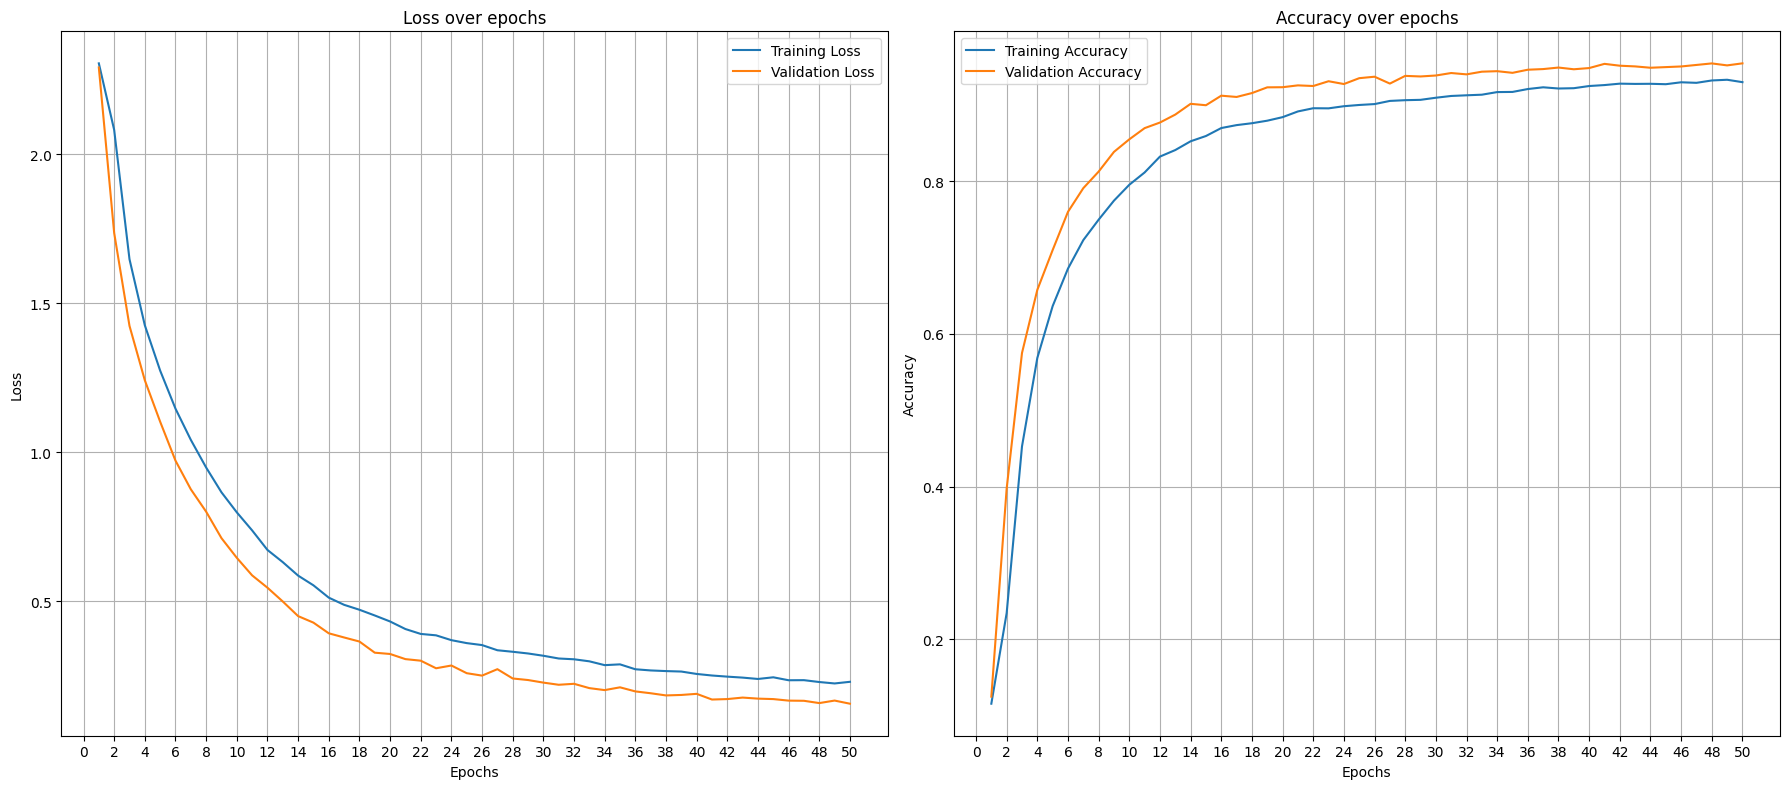

In [57]:
epochs_list = list(range(1, EPOCHS + 1))

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, label='Training Loss')
plt.plot(epochs_list, val_losses, label='Validation Loss')
plt.xticks(ticks=list(range(0, EPOCHS + 1, 2))) 
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.tight_layout()

plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs_list, train_accuracies, label='Training Accuracy')
plt.plot(epochs_list, val_accuracies, label='Validation Accuracy')
plt.xticks(ticks=list(range(0, EPOCHS + 1, 2)))  
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

# Testing

In [58]:
test_labels = []
test_preds = []
test_running_loss = 0
with torch.no_grad():
    for idx, (data, target) in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = data.float().to(device)
        label = target.type(torch.uint8).to(device)
        y_pred = model3(img)
        y_pred_label = torch.argmax(y_pred, dim=1)

        test_labels.extend(label.cpu().detach())
        test_preds.extend(y_pred_label.cpu().detach())

        loss = criterion(y_pred, label)
        test_running_loss += loss.item()

test_loss = test_running_loss / (idx + 1)

test_accuracy = sum(1 for x,y in zip(test_preds, test_labels) if x==y) / len(test_labels)

print("-" * 30)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print("-" * 30)

100%|██████████| 20/20 [00:01<00:00, 14.12it/s]


------------------------------
Test Loss: 0.1535
Test Accuracy: 0.9570
------------------------------
